# Compute focal mechanism distribution

In [115]:
%matplotlib inline
import os
import re
import sys
import h5py
import numpy
import pickle
import matplotlib.pyplot as plt
from oqmbt.oqt_project import OQtProject
from oqmbt.tools.geo import get_idx_points_inside_polygon
from openquake.hmtk.parsers.catalogue.gcmt_ndk_parser import ParseNDKtoGCMT
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueParser
from openquake.hmtk.seismicity.selector import CatalogueSelector


In [116]:
#prj_path = "/Users/kjohnson/GEM/Regions/paisl18/project_9/paisl.oqmbtp"
#os.environ["OQMBT_PROJECT"] = prj_path

In [117]:
def mecclass(plungt, plungb, plungp):
    """
    This is taken from the FMC package.
    See https://josealvarezgomez.wordpress.com/

    It provides a classification of the rupture mechanism based on the
    Kaverina et al. (1996) methodology.

    :parameter plungt:
    :parameter plungb:
    :parameter plungp:

    """
    plunges = numpy.asarray((plungp, plungb, plungt))
    P = plunges[0]
    B = plunges[1]
    T = plunges[2]
    maxplung, axis = plunges.max(0), plunges.argmax(0)
    if maxplung >= 67.5:
        if axis == 0:  # P max
            clase = 'N'  # normal faulting
        elif axis == 1:  # B max
            clase = 'SS'  # strike-slip faulting
        elif axis == 2:  # T max
            clase = 'R'  # reverse faulting
    else:
        if axis == 0:  # P max
            if B > T:
                clase = 'N-SS'  # normal - strike-slip faulting
            else:
                clase = 'N'  # normal faulting
        if axis == 1:  # B max
            if P > T:
                clase = 'SS-N'  # strike-slip - normal faulting
            else:
                clase = 'SS-R'  # strike-slip - reverse faulting
        if axis == 2:  # T max
            if B > P:
                clase = 'R-SS'  # reverse - strike-slip faulting
            else:
                clase = 'R'  # reverse faulting
    return clase

In [118]:
def get_simpler(dct):
    ndct = {'N': [], 'SS': [], 'R': []}
    for key in dct.keys():
        if key == 'SS-N' or key == 'SS-R':
            ndct['SS'] += dct[key]
        elif key == 'N-SS':
            ndct['N'] += dct[key]
        elif key == 'R-SS':
            ndct['R'] += dct[key]
        else:
            ndct[key] += dct[key] 
    return ndct
    
def get_simplified_classification(histo, keys):
    simpl_class = {'N': 0, 'SS': 0, 'R': 0}
    for num, key in zip(histo, keys):
        if key == 'SS-N' or key == 'SS-R':
            simpl_class['SS'] += num
        elif key == 'N-SS':
            simpl_class['N'] += num
        elif key == 'R-SS':
            simpl_class['R'] += num
        else:
            simpl_class[key] += num 
    return simpl_class

In [119]:
#
# read project
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
#

In [120]:
#get catalogue
oqtkp.directory = os.path.dirname(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
catalogue_csv_filename = os.path.join(oqtkp.directory, getattr(model,'catalogue_csv_filename'))
print(catalogue_csv_filename)

/Users/kjohnson/GEM/Regions/paisl18/project_9/../data/ModelInput/PI_AllCrustal.csv


In [121]:
#load catalogue dates
cutoff_magnitude = float(model.catalogue_cutoff_magnitude)
catalogue_parser = CsvCatalogueParser(catalogue_csv_filename)
catalogue = catalogue_parser.read_file()
selector = CatalogueSelector(catalogue, create_copy=True)
selector.within_magnitude_range(cutoff_magnitude, 10.)
dep_max = float(model.catalogue_maximum_depth)
dep_min = float(model.catalogue_minimum_depth)
tmp = selector.within_depth_range(dep_max, dep_min)


Catalogue Attribute field_27 is not a recognised catalogue key
Catalogue Attribute field_23 is not a recognised catalogue key
Catalogue Attribute field_21 is not a recognised catalogue key
Catalogue Attribute 360_1 is not a recognised catalogue key
Catalogue Attribute field_20 is not a recognised catalogue key
Catalogue Attribute field_24 is not a recognised catalogue key
Catalogue Attribute field_26 is not a recognised catalogue key
Catalogue Attribute field_22 is not a recognised catalogue key
Catalogue Attribute field_25 is not a recognised catalogue key


# MUST BE CHANGED! read in final unclassified file

In [122]:
catalogue_uncl = '/Users/kjohnson/GEM/Regions/paisl18/data/catalogues/locations/Reclassified_cr_rep/Simplified/PI_final_unclassified_TR_unclassified.csv' 

In [123]:
#load catalogue dates
cutoff_magnitude = float(model.catalogue_cutoff_magnitude)
catalogue_parser = CsvCatalogueParser(catalogue_uncl)
catalogue_un = catalogue_parser.read_file()
selector = CatalogueSelector(catalogue_un, create_copy=False)
selector.within_magnitude_range(cutoff_magnitude, 10.)
dep_max = float(model.catalogue_maximum_depth)
dep_min = float(model.catalogue_minimum_depth)
tmp_un = selector.within_depth_range(dep_max, dep_min)

/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/selector.py:380: RuntimeWarning: invalid value encountered in greater_equal
  is_valid = np.logical_and(self.catalogue.data['depth'] >= upper_depth,
/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/selector.py:381: RuntimeWarning: invalid value encountered in less
  self.catalogue.data['depth'] < lower_depth)


In [125]:
# set hdf5 file names
gcmt_filename = os.path.join(oqtkp.directory, model.focal_mechanisms_filename)
focal_mech_hdf5_filename = os.path.join(oqtkp.directory, oqtkp.focal_mech_hdf5_filename)
#
# set source ID
try:
    area_source_ids_list = getattr(oqtkp,'active_source_id')
except:
    print('Active source ID not defined in the OQMBT project')
    #area_source_ids_list = ['4']
#area_source_ids_list = ['3']
#
# info
#area_source_ids_list = ['4']
print('Active model is:', model_id)
print('Processing area source with ID:', area_source_ids_list)
print(area_source_ids_list)

Active model is: model09
Processing area source with ID: ['4']
['4']


## Create catalogue for the analysed area source
### Read the declustered catalogue

In [126]:
# 
# parsing the GCMT catalogue
print(gcmt_filename)
parser = ParseNDKtoGCMT(gcmt_filename)
cat_gcmt = parser.read_file()
#
# area source information
src_id = area_source_ids_list[0]
#src_id = '4'
src = model.sources[src_id]
#
# sheck if the area source has a geometry
if 'polygon' in src.__dict__:
    pass
elif src_id in model.nrml_sources:
    src.polygon = model.nrml_sources[src_id].polygon
    src.name = model.nrml_sources[src_id].name
    src.source_id = model.nrml_sources[src_id].source_id
else: 
    print('The source does not have a geometry assigned')
#
# selecting earthquakes within the area source
idxs = range(0, len(cat_gcmt.data['latitude']))
tmp_idxs = get_idx_points_inside_polygon(cat_gcmt.data['longitude'], 
                                                 cat_gcmt.data['latitude'],
                                                 src.polygon.lons, 
                                                 src.polygon.lats, 
                                                 idxs,
                                                 0.0)
print('The number of earthquakes within this polygon %d' % (len(tmp_idxs)))
#
# find the focal mechanisms located within the depth interval under investigation
fidxs = []
for idx in tmp_idxs:
    if ((cat_gcmt.data['depth'][idx] < float(model.catalogue_maximum_depth)) &
        (cat_gcmt.data['depth'][idx] > float(model.catalogue_minimum_depth))):
        fidxs.append(idx)
idxs_selected_fm = fidxs
#
# info
print('The number of earthquakes within this polygon %d' % (len(tmp_idxs)))
print('The number of selected earthquakes %d' % (len(idxs_selected_fm)))

/Users/kjohnson/GEM/Regions/paisl18/project_9/../data/ModelInput/GCMT_20151231.ndk
Parsing catalogue ...
complete. Contains 43341 moment tensors
170.976534961 -24.262981786 -0.006964589818951063 -3919034.8613964017
172.435054736 -24.1077252155 262265.29826255783 -3886467.263510401
173.943520287 -23.9748857834 532591.37580385 -3853886.9548479975
176.647540727 -23.1010975191 1006942.7205643471 -3661882.8851447627
177.934607224 -22.3099649015 1223533.6210942995 -3495649.946505467
178.690315993 -21.270865344 1339614.330079023 -3290980.992787672
178.474227015 -20.7018310336 1293520.2396113896 -3189478.3672181065
178.4828 -20.6958 1294904.5753359532 -3188253.06177854
179.254863948 -18.5155762245 1392046.9491907211 -2785936.655616534
179.257662394 -18.5076737185 1392389.2934045854 -2784504.7867933395
179.983 -16.4594 1478817.2459528858 -2419439.4839988872
-176.641 -20.3535 2123409.315031124 -3034243.590510033
-177.558 -23.852 2050009.659010632 -3709105.230453424
-179.566 -29.855 1821858.92619

In [127]:
len(idxs_selected_fm)

20

ADD CELLS TO CHECK IF CMT IS ALREADYCLASSIFIED AS CRUSTAL ETC FOR THAT AREA

In [128]:
from oqmbt.tools.area import create_catalogue
fcatal = create_catalogue(model, tmp, area_source_ids_list)
tmp = fcatal

170.976534961 -24.262981786 -0.006964589818951063 -3919034.8613964017
172.435054736 -24.1077252155 262265.29826255783 -3886467.263510401
173.943520287 -23.9748857834 532591.37580385 -3853886.9548479975
176.647540727 -23.1010975191 1006942.7205643471 -3661882.8851447627
177.934607224 -22.3099649015 1223533.6210942995 -3495649.946505467
178.690315993 -21.270865344 1339614.330079023 -3290980.992787672
178.474227015 -20.7018310336 1293520.2396113896 -3189478.3672181065
178.4828 -20.6958 1294904.5753359532 -3188253.06177854
179.254863948 -18.5155762245 1392046.9491907211 -2785936.655616534
179.257662394 -18.5076737185 1392389.2934045854 -2784504.7867933395
179.983 -16.4594 1478817.2459528858 -2419439.4839988872
-176.641 -20.3535 2123409.315031124 -3034243.590510033
-177.558 -23.852 2050009.659010632 -3709105.230453424
-179.566 -29.855 1821858.9261900627 -4989724.810246006
-179.7 -30.3 1806278.4577509982 -5090893.690157236
178.711013283 -34.2319733261 1577612.2908039005 -6038183.166127154
17

In [129]:
from datetime import datetime
yr = tmp.data['year']
mo = tmp.data['month']
day = tmp.data['day']
hr = tmp.data['hour']
mnt = tmp.data['minute']
scd = tmp.data['second']
dttmcat = []
for y in range(0,len(yr)-1):
    dttm_cat = datetime(yr[y],mo[y],day[y],hr[y],mnt[y],int(scd[y]))
    dtc = str(dttm_cat)
    dtcd = re.sub("[^0-9]","",dtc)
    dttmcat.append(int(dtcd))
print(len(dttmcat))

757


### Processing the selected earthquakes

In [131]:
dttmgmt = []
keep_idxs = []
for idx in idxs_selected_fm:
    yr = cat_gcmt.data['year'][idx]
    mo = cat_gcmt.data['month'][idx]
    day = cat_gcmt.data['day'][idx]
    hr = cat_gcmt.data['hour'][idx]
    mnt = cat_gcmt.data['minute'][idx]
    scd = cat_gcmt.data['second'][idx]
    dttm_gmt = datetime(yr,mo,day,hr,mnt,int(scd))
    dttm_gmt.strftime("%y%m%d%H%M%S")
    #print(dttm_gmt)
    dtg = str(dttm_gmt)
    dtgd= re.sub("[^0-9]","",dtg)
    dttmgmt.append(int(dtgd))
    keep_idxs.append(idx)
#print(dttmgmt)

1977-10-17 17:26:40
1979-11-16 15:21:25
1982-05-20 22:55:56
1983-10-28 05:57:01
1987-01-17 11:22:05
1987-07-26 21:59:41
1987-07-27 17:53:35
1988-12-17 00:58:15
1990-12-03 05:48:20
1991-02-24 09:36:50
2002-04-21 17:58:47
2004-12-07 04:37:52
2005-06-02 02:11:14
2008-06-16 06:34:50
2009-02-11 09:31:04
2010-02-24 11:57:58
2010-04-25 18:38:45
2010-07-29 05:30:11
2011-08-07 07:01:49
2012-10-15 07:49:01
[19771017172640, 19791116152125, 19820520225556, 19831028055701, 19870117112205, 19870726215941, 19870727175335, 19881217005815, 19901203054820, 19910224093650, 20020421175847, 20041207043752, 20050602021114, 20080616063450, 20090211093104, 20100224115758, 20100425183845, 20100729053011, 20110807070149, 20121015074901]


In [132]:
a1 = dttmgmt
a2 = dttmcat
finidx = []
check_idx_again = []
tot = 0
for i in range(0,len(a1)-1):
    chk = a1[i]
    if chk in a2:
        tot = tot+1
        finidx.append(keep_idxs[i])
    else:
        check_idx_again.append(keep_idxs[i])
#print (tot)
#print(len(finidx))

In [133]:
#print(a1)

[19771017172640, 19791116152125, 19820520225556, 19831028055701, 19870117112205, 19870726215941, 19870727175335, 19881217005815, 19901203054820, 19910224093650, 20020421175847, 20041207043752, 20050602021114, 20080616063450, 20090211093104, 20100224115758, 20100425183845, 20100729053011, 20110807070149, 20121015074901]


In [134]:
idxs_selected_fm = finidx

In [135]:
from oqmbt.tools.area import create_catalogue
fcatal = create_catalogue(model, tmp_un, area_source_ids_list)
tmp_un = fcatal

170.976534961 -24.262981786 -0.006964589818951063 -3919034.8613964017
172.435054736 -24.1077252155 262265.29826255783 -3886467.263510401
173.943520287 -23.9748857834 532591.37580385 -3853886.9548479975
176.647540727 -23.1010975191 1006942.7205643471 -3661882.8851447627
177.934607224 -22.3099649015 1223533.6210942995 -3495649.946505467
178.690315993 -21.270865344 1339614.330079023 -3290980.992787672
178.474227015 -20.7018310336 1293520.2396113896 -3189478.3672181065
178.4828 -20.6958 1294904.5753359532 -3188253.06177854
179.254863948 -18.5155762245 1392046.9491907211 -2785936.655616534
179.257662394 -18.5076737185 1392389.2934045854 -2784504.7867933395
179.983 -16.4594 1478817.2459528858 -2419439.4839988872
-176.641 -20.3535 2123409.315031124 -3034243.590510033
-177.558 -23.852 2050009.659010632 -3709105.230453424
-179.566 -29.855 1821858.9261900627 -4989724.810246006
-179.7 -30.3 1806278.4577509982 -5090893.690157236
178.711013283 -34.2319733261 1577612.2908039005 -6038183.166127154
17

In [136]:
yr = tmp_un.data['year']
mo = tmp_un.data['month']
day = tmp_un.data['day']
hr = tmp_un.data['hour']
mnt = tmp_un.data['minute']
scd = tmp_un.data['second']
dtudcat = []
for y in range(0,len(yr)-1):
    dttm_un = datetime(yr[y],mo[y],day[y],hr[y],mnt[y],int(scd[y]))
    dtu = str(dttm_un)
    dtud = re.sub("[^0-9]","",dtu)
    dtudcat.append(int(dtud))
#print(len(dtudcat))

175


In [137]:
a1 = dttmgmt
a2 = dtudcat

for i in range(0,len(a1)-1):
    chk = a1[i]
    if chk in a2:
        finidx.append(keep_idxs[i])
#print(finidx)
idxs_selected_fm = finidx

[471, 1553, 2889, 6502, 7612, 9333, 19060, 29235]


In [138]:
fmclassification = {}
eventfm = {}
dip_1 = {}
dip_2 = {}
strike_1 = {}
strike_2 = {}
for idx in idxs_selected_fm:
    plungeb = cat_gcmt.data['plunge_b'][idx]
    plungep = cat_gcmt.data['plunge_p'][idx]
    plunget = cat_gcmt.data['plunge_t'][idx]
    mclass = mecclass(plunget, plungeb, plungep)
    eventfm[idx] = mclass
    if mclass in fmclassification:
        fmclassification[mclass] += 1
        dip_1[mclass].append(cat_gcmt.data['dip1'][idx])
        dip_2[mclass].append(cat_gcmt.data['dip2'][idx])
        strike_1[mclass].append(cat_gcmt.data['strike1'][idx])
        strike_2[mclass].append(cat_gcmt.data['strike2'][idx])
    else:
        fmclassification[mclass] = 1
        dip_1[mclass] = [cat_gcmt.data['dip1'][idx]]
        dip_2[mclass] = [cat_gcmt.data['dip2'][idx]]
        strike_1[mclass] = [cat_gcmt.data['strike1'][idx]]
        strike_2[mclass] = [cat_gcmt.data['strike2'][idx]]

In [139]:
#print(cat_gcmt.data['latitude'][idxs_selected_fm])
#print(cat_gcmt.data['dip1'][idxs_selected_fm])
#for idx in idxs_selected_fm:
 #   print((eventfm[idx]))

[-27.91 -16.76 -27.78 -30.21 -26.92 -22.71 -20.52 -28.14]
[ 55.  49.  75.  62.  60.  51.  89.  36.]


### Focal mechanisms histogram

{'SS-N': 2, 'SS': 2, 'R': 1, 'SS-R': 3}
{'SS': 7, 'R': 1, 'N': 0}


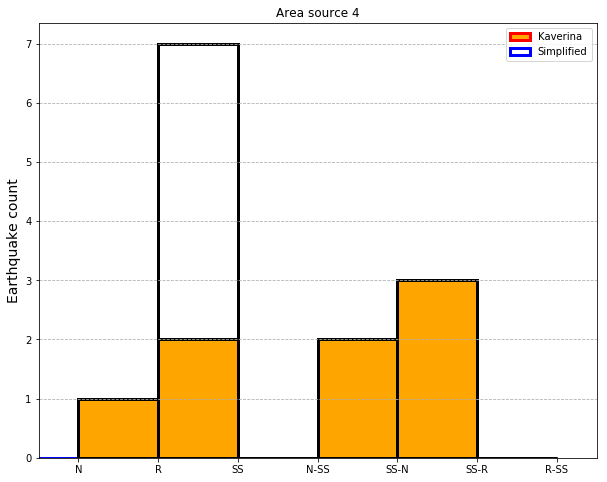

In [140]:
classes = ['N', 'R', 'SS', 'N-SS', 'SS-N', 'SS-R', 'R-SS']

bin_edges = numpy.array([0, 1, 2, 3, 4, 5, 6, 7])
histo = []

for key in classes:
    if key in fmclassification:
        histo.append(fmclassification[key])
    else:
        histo.append(0)

simplified = get_simplified_classification(histo, classes)
print(fmclassification)
print(simplified)

histosimple = []
for key in classes:
    if key in simplified:
        histosimple.append(simplified[key])
    else:
        histosimple.append(0)
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
    
plt.bar(bin_edges[0:-1], histo, 
        width=numpy.diff(bin_edges),
        edgecolor='red', 
        facecolor='orange', 
        linewidth=3, 
        alpha=1.0,
        label='Kaverina')

plt.bar(bin_edges[0:-1], histosimple, 
        width=numpy.diff(bin_edges),
        edgecolor='blue', 
        facecolor='None', 
        linewidth=3, 
        alpha=1.0,
        label='Simplified')

plt.ylabel(r'Earthquake count', fontsize=14)
plt.grid(which='major', axis='y', linestyle='--')
plt.title('Area source %s' % area_source_ids_list[0])

be = numpy.array(bin_edges)
plt.xticks(be[0:-1]+(be[1]-be[0])/2., classes)

xlimits = plt.xlim([0, max(bin_edges)])
leg = plt.legend()

### Strike Vs. Dip distribution for each rupture mechanism class

In [141]:
KAVERINA = {'N'   : 'blue',
            'SS'  : 'green',
            'R'   : 'red',
            'N-SS': 'turquoise',
            'SS-N': 'palegreen',
            'R-SS': 'goldenrod',
            'SS-R': 'yellow' }

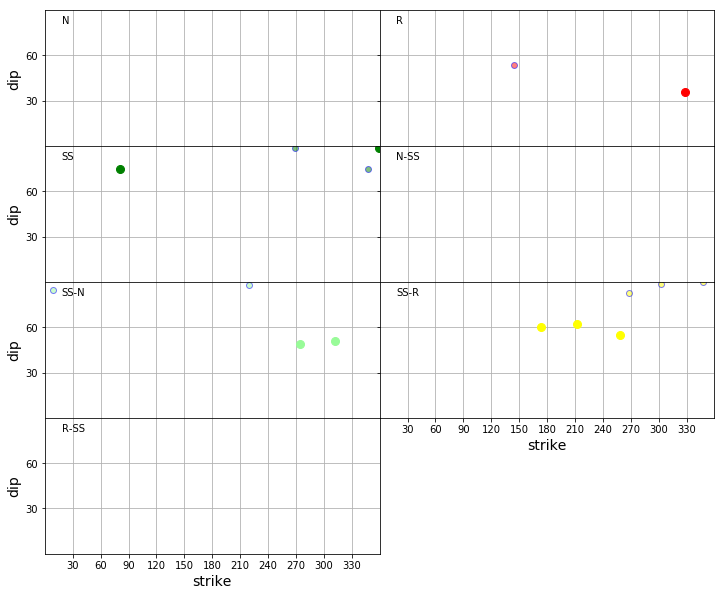

In [142]:
import matplotlib.gridspec as gridspec

if len(fmclassification):
    fs = 14
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(4, 2, wspace=0.0, hspace=0.0)
    for key, igs in zip(classes, range(0, len(classes))):
        ax = plt.subplot(gs[igs])
        if key in strike_1:
            plt.plot(strike_1[key], dip_1[key], 'o', markersize=8, color=KAVERINA[key])
            plt.plot(strike_2[key], dip_2[key], 'o', markersize=6, color=KAVERINA[key], alpha=0.5, markeredgecolor='blue')
        plt.xlim([0, 360])
        plt.ylim([0, 90])
        plt.grid(which='major', )

        x = numpy.arange(30, 90, 30)
        ax.set_yticks(x)
        x = numpy.arange(30, 360, 30)
        ax.set_xticks(x)
        if igs in [0, 1, 2, 3, 4]:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('strike', fontsize=fs)
        if igs in [1, 3, 5]:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('dip', fontsize=fs)
        plt.text(.05,.90,key,
            horizontalalignment='left',
            transform=ax.transAxes)

In [143]:
if len(fmclassification):
    stk1 = get_simpler(strike_1)
    stk2 = get_simpler(strike_2)
    dip1 = get_simpler(dip_1)
    dip2 = get_simpler(dip_2)

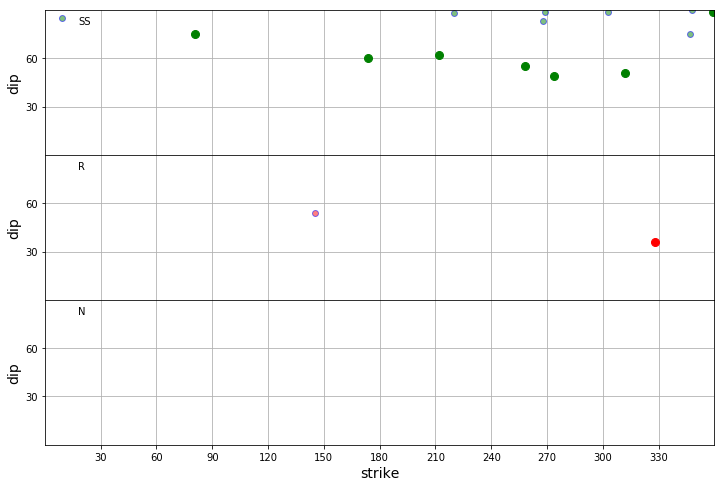

In [144]:
if len(fmclassification):
    fs = 14
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 1, wspace=0.0, hspace=0.0)
    for key, igs in zip(dip1.keys(), range(0, len(dip1.keys()))):
        ax = plt.subplot(gs[igs])
        if key in dip1.keys():
            plt.plot(stk1[key], dip1[key], 'o', markersize=8, color=KAVERINA[key])
            plt.plot(stk2[key], dip2[key], 'o', markersize=6, color=KAVERINA[key], alpha=0.5, markeredgecolor='blue')
        plt.xlim([0, 360])
        plt.ylim([0, 90])
        plt.grid(which='major', )

        x = numpy.arange(30, 90, 30)
        ax.set_yticks(x)
        x = numpy.arange(30, 360, 30)
        ax.set_xticks(x)
        if igs in [0, 1]:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('strike', fontsize=fs)
        ax.set_ylabel('dip', fontsize=fs)
        plt.text(.05,.90,key,
            horizontalalignment='left',
            transform=ax.transAxes)

### Plot focal mechanisms map

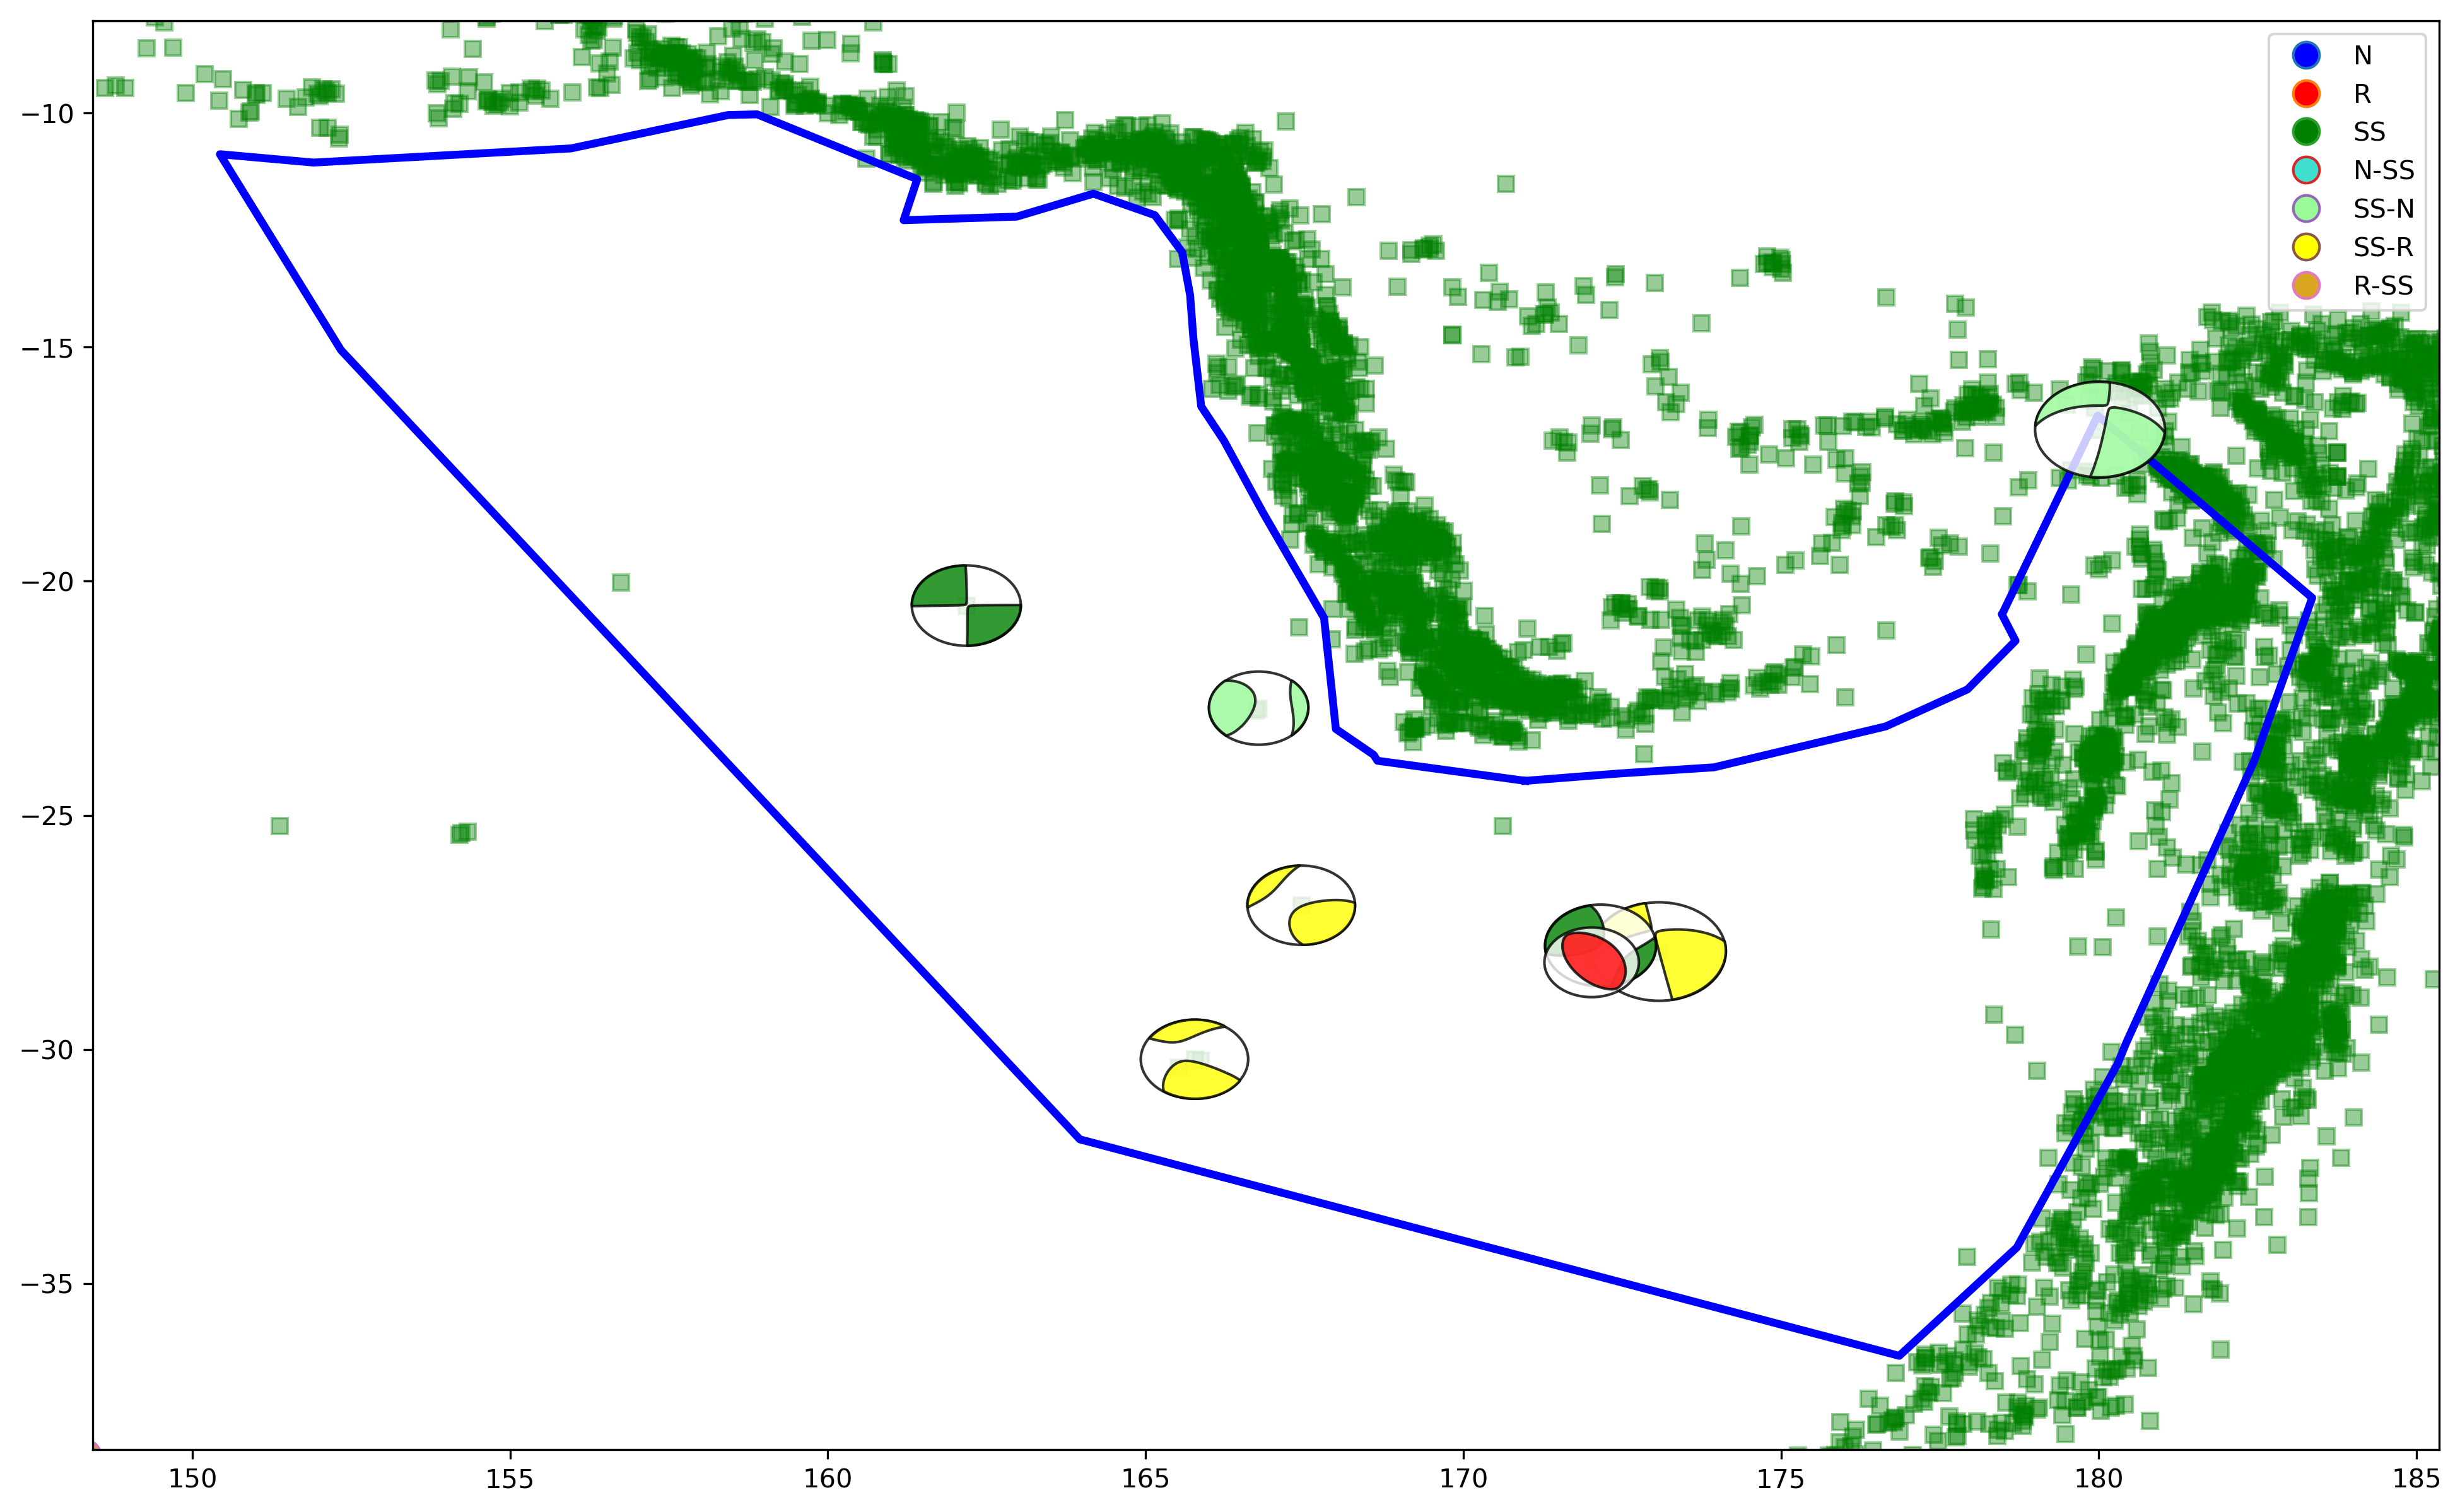

In [176]:
if len(fmclassification):
    import cartopy
    import cartopy.crs as ccrs
    import matplotlib.patheffects as PathEffects
    from obspy.imaging.beachball import beach

    fig = plt.figure(figsize=(16, 10), dpi=300)
    #ax = plt.axes(projection=ccrs.PlateCarree())
    ax = plt.subplot((111))
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), 
    #                  draw_labels=True,
    #                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    #gl.ylabels_left = False

    dlt = 2
    tmp_lons = numpy.array([x+360 if x<0 else x for x in src.polygon.lons])
    limits = [min(tmp_lons)-dlt, min(src.polygon.lats)-dlt, 
              max(tmp_lons)+dlt, max(src.polygon.lats)+dlt]
    #limits = [min(src.polygon.lons)-dlt, min(src.polygon.lats)-dlt, 
     #         max(src.polygon.lons)+dlt, max(src.polygon.lats)+dlt]
    #tmp = ax.coastlines()
    #ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    # set the area for the plot
    #tmp = ax.set_extent([148, 185, -38, -8], ccrs.Geodetic())
    #tmp = ax.set_extent([limits[0], limits[2], limits[1], limits[3]])#, ccrs.Geodetic())
    ax.set_xlim([limits[0], limits[2]])
    ax.set_ylim([limits[1], limits[3]])

    # catalogue
    cat_lons = numpy.array([x+360 if x<0 else x for x in cat_gcmt.data['longitude']])
    #ax.plot(cat_gcmt.data['longitude'], cat_gcmt.data['latitude'], 's',
    ax.plot(cat_lons, cat_gcmt.data['latitude'], 's',
            linewidth=1, alpha=0.4, color='green')
    #        path_effects=[PathEffects.withStroke(linewidth=3, foreground="g")]) 
#    ax.plot(src.polygon.lons, src.polygon.lats, '-', linewidth=3, color='blue', transform=ccrs.Geodetic())
#    ax.plot(cat_gcmt.data['longitude'][idxs_selected_fm], 

    ax.plot(tmp_lons, src.polygon.lats, '-', linewidth=3, color='blue')#, transform=ccrs.Geodetic())
    #ax.plot(cat_lons[idxs_selected_fm], 
    #        cat_gcmt.data['latitude'][idxs_selected_fm], 'o', linewidth=3, color='blue', transform=ccrs.Geodetic())

    # 
    

    for idx, lon, lat, mag in zip(idxs_selected_fm,
                                  #cat_gcmt.data['longitude'][idxs_selected_fm],
                                    cat_lons[idxs_selected_fm],
                                    cat_gcmt.data['latitude'][idxs_selected_fm],
                                    cat_gcmt.data['magnitude'][idxs_selected_fm]):

        eve = cat_gcmt.gcmts[idx]
        com = eve.moment_tensor._to_6component()
        try: 
            bcc = beach(com, xy=(lon, lat), 
                        width=eve.magnitude*0.1,
                        linewidth=1, 
                        zorder=20, 
                        size=mag,
                        facecolor=KAVERINA[eventfm[idx]])
            bcc.set_alpha(0.8)
            bcc.set_label(eventfm[idx])
            ax.add_collection(bcc)
        except:
            print('Error in the moment tensor?', com)
            continue
    #
    

    for lab in classes:
            circ1 = plt.plot(limits[0]-0.1, 
                             limits[1]-0.1, 
                             linestyle="none", 
                             marker="o", 
                             alpha=1.0, 
                             markersize=10.0, 
                             markerfacecolor=KAVERINA[lab], 
                             label=lab)
        # Legend
            leg = plt.legend()
        # Grid
            #grd = ax.gridlines()

## CSV files

In [78]:
if len(fmclassification):
    #
    # set the csv file name
    aa = re.sub('\.hdf5', '', os.path.basename(focal_mech_hdf5_filename))
    csv_filename = '{:s}-{:s}-{:s}.csv'.format(aa, model_id, src_id)
    print(csv_filename)
    #
    #
    path = os.path.join(oqtkp.directory, 'focal_mechs')
    if not os.path.exists(path):
        os.makedirs(path)
        print ('Creating folder: {:s}'.format(path))
    else:
        print ('Folder {:s} exists'.format(path))
    #
    # Writing csv file
    outfile = os.path.join(path, csv_filename)
    print ('Writing {:s}'.format(outfile))
    fou = open(outfile, 'w')
    fou.write('strike,dip,rake,weight\n')
    fou.write('{:.2f},{:.2f},{:.2f},{:.2f}\n'.format(0, 90, 0, 1.0))
    fou.close()

In [79]:
if len(fmclassification):
    #
    # set the csv file name
    aa = re.sub('\.hdf5', '', os.path.basename(focal_mech_hdf5_filename))
    csv_filename = '{:s}-{:s}-{:s}_KJ.csv'.format(aa, model_id, src_id)
    print(csv_filename)
    #
    #
    path = os.path.join(oqtkp.directory, 'focal_mechs')
    if not os.path.exists(path):
        os.makedirs(path)
        print ('Creating folder: {:s}'.format(path))
    else:
        print ('Folder {:s} exists'.format(path))
    #
    # Writing csv file
    outfile = os.path.join(path, csv_filename)
    print ('Writing {:s}'.format(outfile))
    fou = open(outfile, 'w')
    fou.write('lat,lon,kaverina\n')
    for idx in idxs_selected_fm:
        #print((eventfm[idx]))
        #
        fou.write('{0} {1} {2}\n'.format(cat_gcmt.data['longitude'][idx],cat_gcmt.data['latitude'][idx],eventfm[idx]))
    fou.close()

## HDF5 files
### Updating the hdf5 file with focal mechanisms data

In [80]:
if len(fmclassification):
    print('Writing', focal_mech_hdf5_filename)
    fhdf5 = h5py.File(focal_mech_hdf5_filename,'a')
    src_id = area_source_ids_list[0]

    # Update/create model group
    if model_id in fhdf5.keys():
        print('Group exists. Set group %s' % (model_id))
        grp = fhdf5[model_id]
    else:
        print('Create group: %s' % (model_id))
        grp = fhdf5.create_group(model_id)

    # Update/create source group
    if src_id in fhdf5[model_id].keys():
        print('Group exists. Set group %s' % (src_id))
        grpsrc = fhdf5[model_id][src_id]
    else:
        print('Create group: %s' % (src_id))
        grpsrc = fhdf5[model_id].create_group(src_id)

    # Update/create datasets
    dset_ids = ['kaverina_histogram', 'simplified_histogram']
    for dset_id in dset_ids:
        if dset_id in grpsrc:
            del grpsrc[dset_id]

    dataset = grpsrc.create_dataset('kaverina_histogram', data=histo)
    dataset.attrs['labels'] = '-'.join(['%s' % lab for lab in classes])
    dataset = grpsrc.create_dataset('simplified_histogram', data=histosimple)
    dataset.attrs['labels'] = '-'.join(['%s' % lab for lab in classes])

    strike_simpl_1 = stk1
    strike_simpl_2 = stk1
    dip_simpl_1 = dip1
    dip_simpl_2 = dip2

    for tpe in ['strike_1', 'strike_2', 'dip_1', 'dip_2',
               'strike_simpl_1', 'strike_simpl_2', 'dip_simpl_1', 'dip_simpl_2']:

        # Update/create source group
        if tpe in fhdf5[model_id][src_id].keys():
            print('Group exists. Set group %s' % (tpe))
            grpsrc = fhdf5[model_id][src_id][tpe]
            # cleaning
            for dset_id in grpsrc:
                del grpsrc[dset_id]   
        else:
            print('Create group: %s' % (tpe))
            grpsrc = fhdf5[model_id][src_id].create_group(tpe)

        tdct = eval(tpe)
        for key in tdct.keys():
            dataset = grpsrc.create_dataset(key, data=tdct[key])

    fhdf5.close()

### Initialising the hdf5 containing the nodal plane distribution

In [81]:
if len(fmclassification):
    #
    # open the hdf5 containing the nodal plane information
    nodal_plane_dist_filename = os.path.join(oqtkp.directory, model.nodal_plane_dist_filename)
    fhdf5 = h5py.File(nodal_plane_dist_filename,'a')
    #
    # add the dataset for the current area source, if missing
    if src_id in fhdf5.keys():
        print ('Datasets already available')
    else:
        print ('Adding dummy dataset')
        x = numpy.zeros(1, dtype=[('strike','f4'),('dip', 'f4'), ('rake', 'f4'), ('wei', 'f4')])
        dset = fhdf5.create_dataset(src_id, data=x)
    fhdf5.close()